Best Use with Hardware Accelerator (GPU)

In [1]:
import numpy as np
import zipfile
import os
import shutil
import math
import tensorflow as tf
import tensorflow.keras.layers as layers
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input
from keras.callbacks import LearningRateScheduler

In [2]:
print("Please put your kaggle.json here! (Name must be kaggle.json)!")
uploaded_file = files.upload()
content_directory = "/content/"
kaggle_json_name = 'kaggle.json'
try:
  kaggle_json_item = content_directory + kaggle_json_name
  open(kaggle_json_item, "r")
  print("Kaggle.json has been uploaded!")
  shutil.move(kaggle_json_item, "/root/" + kaggle_json_name)
except FileNotFoundError as e:
  items = uploaded_file.items()
  print("Got different filename instead of 'kaggle.json'. Please rename the file and try again!")
  for item in items:
    os.remove(content_directory + item[0])

Please put your kaggle.json here! (Name must be kaggle.json)!


Saving kaggle.json to kaggle.json
Kaggle.json has been uploaded!


In [3]:
root_directory = '/root/'
kaggle_directory = root_directory + ".kaggle/"
try:
  os.mkdir(kaggle_directory)
except FileExistsError as e:
  print(".kaggle directory has been created! Skipping creating directory...")
try:
  shutil.move(root_directory + kaggle_json_name, kaggle_directory)
  ! chmod 600 /root/.kaggle/kaggle.json
except:
  print(kaggle_json_name + " not found in root directory. It may have been moved or deleted!")

print("Process finished!")

Process finished!


In [4]:
! pip install kaggle
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset

 98% 737M/750M [00:07<00:00, 112MB/s] 
100% 750M/750M [00:07<00:00, 108MB/s]


In [5]:
zip_path = content_directory + 'stanford-dogs-dataset.zip'
dataset_path = content_directory + 'datasets/'
annotations_directory = dataset_path + 'annotations/'
zip_file = zipfile.ZipFile(zip_path, 'r')
zip_file.extractall(dataset_path)
zip_file.close()

shutil.rmtree(annotations_directory)
print("Images have been successfully extracted!")

Images have been successfully extracted!


In [6]:
# Rename all folders, so all names consist of words only
def split_values(labels, split_char, start_split_index):
  list_labels = []
  for label in labels:
    temp_label = label.split(split_char)
    temp_sliced_labels = temp_label[:][start_split_index:]
    new_string = ""
    for temp_sliced_label in temp_sliced_labels:
      new_string += str(temp_sliced_label) + ' '
    list_labels.append(new_string)
  return list_labels

images_directory_path = dataset_path + 'images/Images/'
all_images_directory_name = sorted(os.listdir(images_directory_path))
first_split_labels = split_values(all_images_directory_name, '-', 1)
second_split_labels = split_values(first_split_labels, '_', 0)
currentIndex = 0
for image_directory_name in all_images_directory_name:
  print("Renaming {} to {}".format(images_directory_path + image_directory_name, images_directory_path + second_split_labels[currentIndex]))
  os.rename(images_directory_path + image_directory_name, images_directory_path + second_split_labels[currentIndex])
  currentIndex += 1
print("All Directories' name have been fixed! Happy classifying!")

Renaming /content/datasets/images/Images/n02085620-Chihuahua to /content/datasets/images/Images/Chihuahua  
Renaming /content/datasets/images/Images/n02085782-Japanese_spaniel to /content/datasets/images/Images/Japanese spaniel  
Renaming /content/datasets/images/Images/n02085936-Maltese_dog to /content/datasets/images/Images/Maltese dog  
Renaming /content/datasets/images/Images/n02086079-Pekinese to /content/datasets/images/Images/Pekinese  
Renaming /content/datasets/images/Images/n02086240-Shih-Tzu to /content/datasets/images/Images/Shih Tzu  
Renaming /content/datasets/images/Images/n02086646-Blenheim_spaniel to /content/datasets/images/Images/Blenheim spaniel  
Renaming /content/datasets/images/Images/n02086910-papillon to /content/datasets/images/Images/papillon  
Renaming /content/datasets/images/Images/n02087046-toy_terrier to /content/datasets/images/Images/toy terrier  
Renaming /content/datasets/images/Images/n02087394-Rhodesian_ridgeback to /content/datasets/images/Images/

In [7]:
# All labels here will have only 150 images, so the number of images in each label are the same
def cut_to_number_of_data(label_directory, min_data):
  images = os.listdir(label_directory)
  length_images = len(images)
  if (length_images > min_data):
    for index in range(min_data, length_images):
      os.remove(label_directory + "/" + images[index])
labels = os.listdir(images_directory_path)
for label in labels:
  cut_to_number_of_data(images_directory_path + label, 150)

print("Successfully deleted overflowed data!")

Successfully deleted overflowed data!


In [8]:
# Reduce the number of labels. In this case, there are 70 labels
labels = os.listdir(images_directory_path)
def cut_to_number_of_labels(images_directory_path, starting_index):
  for index in range (starting_index, len(labels)):
    shutil.rmtree(images_directory_path + "/" + labels[index])

cut_to_number_of_labels(images_directory_path, 70)
print("Successfully narrowing number of labels!")

Successfully narrowing number of labels!


In [14]:
def get_image_data_generator(rotate):
  return ImageDataGenerator(validation_split=0.2,
                             rescale=1./255,
                             rotation_range=rotate,
                             horizontal_flip=True,
                             fill_mode='nearest')
  
def datagen_flow_from_directory(base_dir, datagen, subset_type):
  return datagen.flow_from_directory(
    base_dir,
    target_size=(331,331),
    subset=subset_type,
    batch_size=8,
    class_mode="categorical")
  

datagen = get_image_data_generator(5)
train_generator = datagen_flow_from_directory(images_directory_path, datagen, "training")
val_generator = datagen_flow_from_directory(images_directory_path, datagen, "validation")

Found 8400 images belonging to 70 classes.
Found 2099 images belonging to 70 classes.


In [15]:
class ReportCallback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs=None):
    print("Training has been started!")
  def on_train_end(self, logs=None):
    print("Training has ended!")
  def on_epoch_end(self, batch, logs=None):
    expected_value = 0.921
    if (logs["accuracy"] >= expected_value and logs["val_accuracy"] >= expected_value):
      print("\nTraining model have reached ", expected_value, ". Exit training process...")
      self.model.stop_training = True


def get_dense_layer(units):
  return layers.Dense(units, activation="relu")

def get_output_layer(class_count):
  return layers.Dense(class_count,
                      activation="softmax")

def get_conv_layer_2D(units):
  return layers.Conv2D(units,
                       (3,3),
                       strides=1,
                       dilation_rate=2,
                       activation="relu",
                       padding="same")


def get_max_pooling_2D_layer():
  return layers.MaxPooling2D(2,2)

def get_first_nas_net_layer():
  return tf.keras.applications.NASNetLarge(weights="imagenet", include_top=False, input_shape=(331,331,3))

def step_decay(epoch):
  initial_lrate = 0.0005
  drop = 0.5
  epochs_drop = 15.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate


model = tf.keras.models.Sequential([get_first_nas_net_layer(),
                                    get_conv_layer_2D(64),
                                    get_max_pooling_2D_layer(),
                                    get_conv_layer_2D(128),
                                    get_max_pooling_2D_layer(),
                                    layers.BatchNormalization(),
                                    layers.Flatten(),
                                    get_dense_layer(128),
                                    get_dense_layer(256),
                                    layers.BatchNormalization(),
                                    get_output_layer(70)])

model.layers[0].trainable = False
report_callback = ReportCallback()
report_callback.model = model

lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

result = model.fit(train_generator,
                   batch_size=8,
                   validation_steps=10,
                   steps_per_epoch=10,
                   epochs=40,
                   callbacks=[report_callback, lrate],
                   validation_data=val_generator)

Training has been started!
Epoch 1/40
10/10 [==============================] - 18s 2s/step - loss: 4.3633 - accuracy: 0.0625 - val_loss: 4.4198 - val_accuracy: 0.0375
Epoch 2/40
10/10 [==============================] - 13s 1s/step - loss: 3.5286 - accuracy: 0.2625 - val_loss: 4.2939 - val_accuracy: 0.1500
Epoch 3/40
10/10 [==============================] - 13s 1s/step - loss: 3.1099 - accuracy: 0.3500 - val_loss: 4.0429 - val_accuracy: 0.1375
Epoch 4/40
10/10 [==============================] - 13s 1s/step - loss: 2.8291 - accuracy: 0.4000 - val_loss: 3.5009 - val_accuracy: 0.1875
Epoch 5/40
10/10 [==============================] - 13s 1s/step - loss: 2.3184 - accuracy: 0.5500 - val_loss: 3.1798 - val_accuracy: 0.3250
Epoch 6/40
10/10 [==============================] - 13s 1s/step - loss: 2.2382 - accuracy: 0.5625 - val_loss: 3.2641 - val_accuracy: 0.3500
Epoch 7/40
10/10 [==============================] - 13s 1s/step - loss: 1.7399 - accuracy: 0.6375 - val_loss: 2.4797 - val_accuracy: 

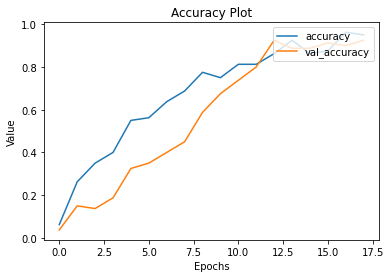

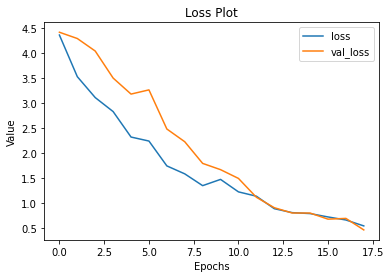

In [17]:
def plot_data(metric1, metric2, title):
  plt.plot(result.history[metric1])
  plt.plot(result.history[metric2])
  plt.title(title)
  plt.ylabel("Value")
  plt.xlabel("Epochs")
  plt.legend([metric1, metric2], loc="upper right")
  plt.show()

metrics = [["accuracy", "val_accuracy", "Accuracy Plot"], ["loss", "val_loss", "Loss Plot"]]

for [metric1, metric2, title] in metrics:
  plot_data(metric1, metric2, title)

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile("model.tflite", "wb") as f:
  f.write(tflite_model)
print("Successfully converted the model to TFLite format!")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpb8afbd28/assets
Successfully converted the model to TFLite format!
